In [42]:
import pandas as pd
import walnut

# Example 3.2

### Deep neural network using a custom model

The goal of this model is to classify iris species based on numerical features.

### Step 1: Prepare data
You will need to download the dataset from https://www.kaggle.com/datasets/uciml/iris and place it into the *data* directory.

In [43]:
data_orig = pd.read_csv('data/iris.csv')
data = data_orig.copy()
data.drop(columns=['Id'], inplace=True)

In [44]:
data_enc = walnut.preprocessing.encoding.pd_categorical_to_numeric(data, columns=["Species"])

In [45]:
tensor = walnut.pd_to_tensor(data_enc)
t_train, t_val, t_test = walnut.preprocessing.split_train_val_test(tensor)

Features and labels are now seperated.

In [46]:
x_train, y_train = t_train[:, :-1], t_train[:, -1].astype("int")
x_val, y_val = t_val[:, :-1], t_val[:, -1].astype("int")
x_test, y_test = t_test[:, :-1], t_test[:, -1].astype("int")

In [47]:
x_train = walnut.preprocessing.normalize(x_train, axis=0)
x_val = walnut.preprocessing.normalize(x_val, axis=0)
x_test = walnut.preprocessing.normalize(x_test, axis=0)

In [48]:
print (f'{x_train.shape=}')
print (f'{y_train.shape=}')

print (f'{x_val.shape=}')
print (f'{y_val.shape=}')

print (f'{x_test.shape=}')
print (f'{y_test.shape=}')

x_train.shape=(120, 4)
y_train.shape=(120,)
x_val.shape=(15, 4)
y_val.shape=(15,)
x_test.shape=(15, 4)
y_test.shape=(15,)


### Step 2: Build a custom model
If you want to define very specifically what the forward and backward pass of your model should look like, you can build your own custom model instead of using the predefined sequential model.

In [49]:
import walnut.nn as nn
from walnut.nn import Model
from walnut.nn.layers import *
from walnut.nn.inits import *

n_hidden = 100
gain = get_gain("tanh")
init = kaiming_normal

class MyCustomModel(Model):
    def __init__(self):
        super().__init__()

        # define your layers
        self.lin1 = Linear(4, n_hidden, weights=init((4, n_hidden), gain))
        self.tanh1 = Tanh()
        self.lin2 = Linear(n_hidden, n_hidden, weights=init((n_hidden, n_hidden), gain))
        self.tanh2 = Tanh()
        self.lin3 = Linear(n_hidden, 3, weights=init((n_hidden, 3)))

        self.layers = [self.lin1, self.tanh1, self.lin2, self.tanh2, self.lin3]

    def __call__(self, x):

        # define the forward pass
        y = self.lin3(self.tanh2(self.lin2(self.tanh1(self.lin1(x)))))

        # define the backward pass
        self.backward = lambda y_grad: self.lin1.backward(self.tanh1.backward(self.lin2.backward(self.tanh2.backward(self.lin3.backward(y_grad)))))
        
        return y

model = MyCustomModel()

In [50]:
model.compile(
    optimizer=nn.optimizers.SGD(),
    loss_fn=nn.losses.Crossentropy(),
    metric=nn.metrics.get_accuracy
)

In [51]:
model

MyCustomModel()
Linear(in_channels=4, out_channels=100, use_bias=True)
Tanh()
Linear(in_channels=100, out_channels=100, use_bias=True)
Tanh()
Linear(in_channels=100, out_channels=3, use_bias=True)

In [52]:
from walnut.nn.analysis import model_summary
model_summary(model, (4,))

---------------------------------------------------------------
      Layer                Output Shape            # Parameters
 0. 0 Linear               (-1, 100)                        500
 1. 0 Tanh                 (-1, 100)                          0
 2. 0 Linear               (-1, 100)                      10100
 3. 0 Tanh                 (-1, 100)                          0
 4. 0 Linear               (-1, 3)                          303

Total parameters: 10903


### Step 3: Train the model

In [53]:
train_loss_hist, val_loss_hist = model.train(x_train, y_train, epochs=100, val_data=(x_val, y_val))

epoch     1/  100 | step      2.00 ms | loss   1.6417 | val_loss   1.2615
epoch    10/  100 | step      2.97 ms | loss   0.6138 | val_loss   0.5293
epoch    20/  100 | step      3.00 ms | loss   0.4545 | val_loss   0.4119
epoch    30/  100 | step      2.00 ms | loss   0.3979 | val_loss   0.3690
epoch    40/  100 | step      2.00 ms | loss   0.3657 | val_loss   0.3461
epoch    50/  100 | step      2.00 ms | loss   0.3439 | val_loss   0.3317
epoch    60/  100 | step      2.00 ms | loss   0.3276 | val_loss   0.3216
epoch    70/  100 | step      2.00 ms | loss   0.3148 | val_loss   0.3138
epoch    80/  100 | step      3.00 ms | loss   0.3042 | val_loss   0.3076
epoch    90/  100 | step      2.00 ms | loss   0.2953 | val_loss   0.3022
epoch   100/  100 | step      2.00 ms | loss   0.2874 | val_loss   0.2976


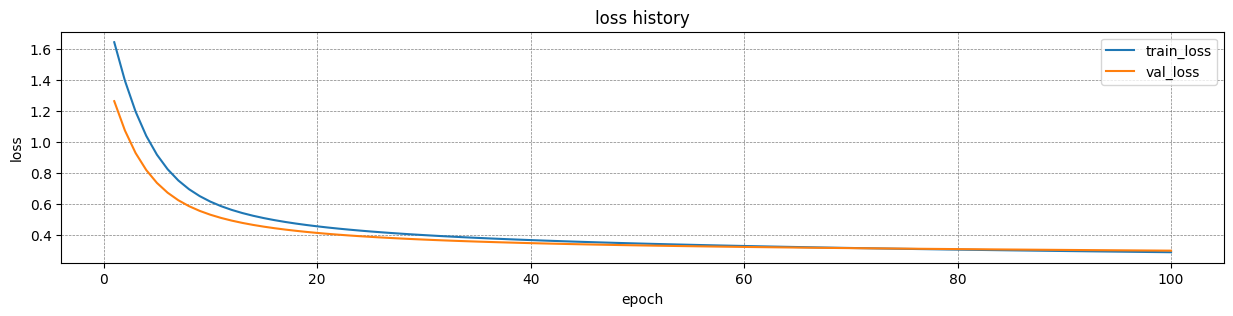

In [54]:
traces = {
    "train_loss" : train_loss_hist,
    "val_loss" : val_loss_hist
}

nn.analysis.plot_curve(traces=traces, figsize=(15, 3), title="loss history", x_label="epoch", y_label="loss")

### Step 4: Evaluate the model
Using the defined metric, the model's performance can be evaluated using testing/validation data.

In [55]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'loss {loss:.4f}')
print(f'accuracy {100*accuracy:.2f}')

loss 0.1267
accuracy 93.33
